In [22]:
import pandas as pd
import numpy as np
import sqlite3
import scipy as sp
import sklearn as skl

from sklearn.svm import SVC
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.neural_network import MLPRegressor,MLPClassifier
import sklearn.model_selection as ms
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import cross_validate,KFold
from sklearn import metrics
from sklearn import cross_validation
from sklearn import preprocessing
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingClassifier,GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import RadiusNeighborsRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import linear_model
import keras
from keras import optimizers,regularizers


In [23]:
#import data
engine = sqlite3.connect('CleanData-Apr15')
totaldata_df = pd.read_sql('select * from data', engine)


In [24]:
#split and scale
train_data, test_data= ms.train_test_split(totaldata_df, test_size=0.3, random_state=42)
scaler = StandardScaler()
scaler.fit(train_data[['CENTROID_X','CENTROID_Y','DistCBD','pop_density','housing_ratio']])
train_data[['CENTROID_X','CENTROID_Y','DistCBD','pop_density','housing_ratio']] =scaler.transform(train_data[['CENTROID_X','CENTROID_Y','DistCBD','pop_density','housing_ratio']])
test_data[['CENTROID_X','CENTROID_Y','DistCBD','pop_density','housing_ratio']] =scaler.transform(test_data[['CENTROID_X','CENTROID_Y','DistCBD','pop_density','housing_ratio']])

X_train=train_data.drop(labels=['WIDTH'],axis='columns')
y_train=train_data[['WIDTH']]

X_test=test_data.drop(labels=['WIDTH'],axis='columns')
y_test=test_data[['WIDTH']]



C:\Users\Umair\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\Umair\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\Umair\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

In [25]:
wdataval=y_train.values
std=wdataval.std()/2
lb=wdataval.mean()-wdataval.std()/2
ub=wdataval.mean()+wdataval.std()/2
mean=wdataval.mean()

In [26]:
def error_bounded(err_matnew,l=0,u=1000,verbose=0):
    err_matnew=err_matnew[(err_matnew[:,0]<=u)&(err_matnew[:,0]>=l)]
    temp1=np.square(err_matnew[:,1]-err_matnew[:,0])
    temp2=np.abs(err_matnew[:,1]-err_matnew[:,0])
    temp3=np.divide(temp2,err_matnew[:,0])
    if verbose==1:
        print('error: for '+str(l)+'=<width<='+str(u))
        print(np.array([np.sqrt(sum(temp1)/temp1.shape[0]),sum(temp2)/temp1.shape[0],100*sum(temp3)/temp1.shape[0]]))
        print('\n')
    return np.array([np.sqrt(sum(temp1)/temp1.shape[0]),sum(temp2)/temp1.shape[0],100*sum(temp3)/temp1.shape[0]])

In [27]:
def keras_nn_model(dim,act,l1,reg=1e-5):
    model = Sequential()
    model.add(Dense(l1, input_dim=dim, kernel_initializer='uniform', activation=act,kernel_regularizer=regularizers.l2(reg)))
    model.add(Dense(1, kernel_initializer='uniform'))
    adam=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0, amsgrad=False)
    model.compile(loss='mean_absolute_percentage_error', optimizer=adam)
    return model

In [28]:
def cross_val_keras(input_data,test_data,input_labels,test_labels,layer,reg,act,verbose=0):
    test_labels=test_labels.ravel()
    input_labels=input_labels.ravel()
    err_matnew=np.empty((1,2))
    kf = KFold(n_splits=7,random_state=9, shuffle=True)
    seed = 9
    np.random.seed(seed)
    count=0
    for train_index, test_index in kf.split(input_data):
        X_cvtrain = input_data.iloc[train_index]
        X_cvtest = input_data.iloc[test_index]

        y_cvtrain = input_labels[train_index]
        y_cvtrain=y_cvtrain.squeeze()
        y_cvtrain=y_cvtrain.ravel()

        y_cvtest = input_labels[test_index]
        y_cvtest=y_cvtest.squeeze()
        y_cvtest=y_cvtest.ravel()
                    
        keras_model=keras_nn_model(X_cvtrain.shape[1],act,layer,reg)
        keras_model.fit(x=X_cvtrain, y=y_cvtrain, batch_size=200, epochs=5, verbose=0, validation_split=0, shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None, validation_steps=None)
        predictions=keras_model.predict(X_cvtest, batch_size=None, verbose=0, steps=None).ravel()
        
        err_vec=np.column_stack((y_cvtest,predictions))
        err_matnew=np.concatenate((err_matnew,err_vec),axis=0)
        temp1=np.square(predictions-y_cvtest)
        temp2=np.abs(predictions-y_cvtest)
        temp3=np.divide(temp2,y_cvtest)
        count+=1
        if verbose==1:
            print('cv error: '+str(count)+' Fold')
            print(np.array([np.sqrt(sum(temp1)/temp1.shape[0]),sum(temp2)/temp1.shape[0],100*sum(temp3)/temp1.shape[0]]))

    err_matnew=err_matnew[1:,:]     
    
    temp1=np.square(err_matnew[:,1]-err_matnew[:,0])
    temp2=np.abs(err_matnew[:,1]-err_matnew[:,0])
    temp3=np.divide(temp2,err_matnew[:,0])
    cv_error=np.array([np.sqrt(sum(temp1)/temp1.shape[0]),sum(temp2)/temp1.shape[0],100*sum(temp3)/temp1.shape[0]])
    print('cv_error:')
    print(cv_error)
    return cv_error,err_matnew

In [29]:
def cross_val(input_data,test_data,input_labels,test_labels,model=linear_model.LinearRegression(),model_type='other',verbose=0):
    
    test_labels=test_labels.ravel()
    input_labels=input_labels.ravel()
    err_matnew=np.empty((1,2))
    kf = KFold(n_splits=8,random_state=9, shuffle=True)
    seed = 9
    np.random.seed(seed)
    count=0
    for train_index, test_index in kf.split(input_data):
        X_cvtrain = input_data[train_index]
        X_cvtest = input_data[test_index]

        y_cvtrain = input_labels[train_index]
        y_cvtrain=y_cvtrain.squeeze()
        y_cvtrain=y_cvtrain.ravel()

        y_cvtest = input_labels[test_index]
        y_cvtest=y_cvtest.squeeze()
        y_cvtest=y_cvtest.ravel()
        
        model.fit(X_cvtrain,y_cvtrain)
        predictions = model.predict(X_cvtest).ravel()

        err_vec=np.column_stack((y_cvtest,predictions))
        err_matnew=np.concatenate((err_matnew,err_vec),axis=0)

        temp1=np.square(predictions-y_cvtest)
        temp2=np.abs(predictions-y_cvtest)
        temp3=np.divide(temp2,y_cvtest)
        count+=1
        if verbose==1:
            print('cv error: '+str(count)+' Fold')
            print(np.array([np.sqrt(sum(temp1)/temp1.shape[0]),sum(temp2)/temp1.shape[0],100*sum(temp3)/temp1.shape[0]]))

    err_matnew=err_matnew[1:,:]     
    
    temp1=np.square(err_matnew[:,1]-err_matnew[:,0])
    temp2=np.abs(err_matnew[:,1]-err_matnew[:,0])
    temp3=np.divide(temp2,err_matnew[:,0])
    cv_error=np.array([np.sqrt(sum(temp1)/temp1.shape[0]),sum(temp2)/temp1.shape[0],100*sum(temp3)/temp1.shape[0]])
    print('cv_error:')
    print(cv_error)
    return cv_error,err_matnew

In [30]:
#learn MAPE test error on various road widths
keras_model=keras_nn_model(X_train.shape[1],'relu',100,0)
keras_model.fit(x=X_train, y=y_train.values.ravel(), batch_size=200, epochs=10, verbose=0, validation_split=0, shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None, validation_steps=None)
pred=keras_model.predict(X_test, batch_size=None, verbose=0, steps=None)
rkeras=[error_bounded(np.column_stack((y_test.values.ravel(),pred)),2,lb)[-1],error_bounded(np.column_stack((y_test.values.ravel(),pred)),lb,ub)[-1],error_bounded(np.column_stack((y_test.values.ravel(),pred)),ub,1000)[-1]]

mlp = MLPRegressor(hidden_layer_sizes=100,activation='relu', max_iter=1000, alpha=1, early_stopping=True,random_state=42)
mlp.fit(X_train,y_train.values.ravel())
pred=mlp.predict(X_test)
rmlp=[error_bounded(np.column_stack((y_test.values.ravel(),pred)),2,lb)[-1],error_bounded(np.column_stack((y_test.values.ravel(),pred)),lb,ub)[-1],error_bounded(np.column_stack((y_test.values.ravel(),pred)),ub,1000)[-1]]

regr = RandomForestRegressor(n_estimators = 30, min_samples_split = 68, random_state=42)
regr.fit(X_train,y_train.values.ravel())
pred = regr.predict(X_test)
rrf=[error_bounded(np.column_stack((y_test.values.ravel(),pred)),2,lb)[-1],error_bounded(np.column_stack((y_test.values.ravel(),pred)),lb,ub)[-1],error_bounded(np.column_stack((y_test.values.ravel(),pred)),ub,1000)[-1]]

reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)
pred = reg.predict(X_test)
error_bounded(np.column_stack((y_test.values.ravel(),pred)))

reg = linear_model.Ridge(alpha=1)
reg.fit(X_train, y_train)
pred = reg.predict(X_test)
rrdge=[error_bounded(np.column_stack((y_test.values.ravel(),pred)),2,lb)[-1],error_bounded(np.column_stack((y_test.values.ravel(),pred)),lb,ub)[-1],error_bounded(np.column_stack((y_test.values.ravel(),pred)),ub,1000)[-1]]

In [31]:
#graph of error vs data size

def err_vs_size(train_data,train_width,X_test,y_test,model):
    size_ind=np.arange(1,11)*2036
    size_ind[-1]=train_data.shape[0]-1
    rmse=[]
    mpe=[]
    for split in size_ind:
        split_Xtrain=train_data[:split,:]
        split_ytrain=train_width[:split]
        model.fit(split_Xtrain,split_ytrain)
        pred=model.predict(X_test)
        err=error_bounded(np.column_stack((y_test,pred)))
        rmse.append(err[0])
        mpe.append(err[2])
    return [rmse,mpe]

def err_vs_size_keras(train_data,train_width,X_test,y_test):
    size_ind=np.arange(1,11)*2036
    size_ind[-1]=train_data.shape[0]-1
    rmse=[]
    mpe=[]
    for split in size_ind:
        split_Xtrain=train_data[:split,:]
        split_ytrain=train_width[:split]
        keras_model=keras_nn_model(split_Xtrain.shape[1],'relu',100,0)
        keras_model.fit(x=split_Xtrain, y=split_ytrain, batch_size=200, epochs=10, verbose=0, validation_split=0, shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None, validation_steps=None)
        pred=keras_model.predict(X_test, batch_size=None, verbose=0, steps=None)
        err=error_bounded(np.column_stack((y_test,pred)))
        rmse.append(err[0])
        mpe.append(err[2])
    return [rmse,mpe]

In [32]:
#test error vs data size
plots_list={}
errors=err_vs_size(X_train.values,y_train.values.ravel(),X_test.values,y_test.values.ravel(),model=linear_model.Ridge())
plots_list['Ridge']=errors

errors=err_vs_size(X_train.values,y_train.values.ravel(),X_test.values,y_test.values.ravel(),model=MLPRegressor(hidden_layer_sizes=100,activation='relu',solver="adam", max_iter=1000,alpha=1,early_stopping=True,batch_size=200,validation_fraction=0.1,learning_rate='constant',shuffle=True,random_state=42,momentum=0,nesterovs_momentum=False))
plots_list['NN']=errors

errors=err_vs_size_keras(X_train.values,y_train.values.ravel(),X_test.values,y_test.values.ravel())
plots_list['Keras']=errors

errors=err_vs_size(X_train.values,y_train.values.ravel(),X_test.values,y_test.values.ravel(),model= RandomForestRegressor(n_estimators = 30, min_samples_split = 68, random_state=42))
plots_list['Random Forest']=errors

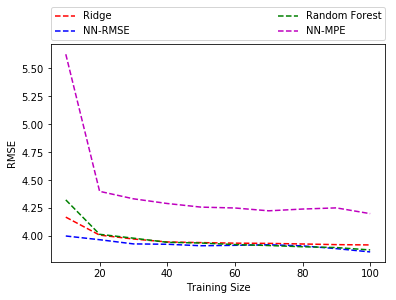

In [33]:
#plot rmse test error vs data size

plt.plot(range(10,110,10),plots_list['Ridge'][0],'r--',label='Ridge')
plt.plot(range(10,110,10),plots_list['NN'][0],'b--',label='NN-RMSE')
plt.plot(range(10,110,10),plots_list['Random Forest'][0],'g--',label='Random Forest')
plt.plot(range(10,110,10),plots_list['Keras'][0],'m--',label='NN-MPE')
plt.xlabel('Training Size')
plt.ylabel('RMSE')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.savefig('plot1.png', bbox_inches='tight')
plt.show()


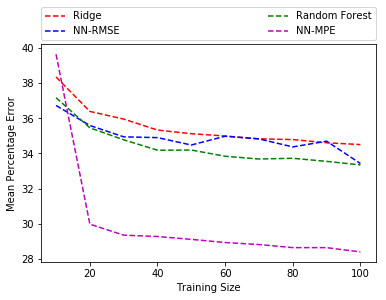

In [34]:
#plot mape test error vs data size

plt.plot(range(10,110,10),plots_list['Ridge'][1],'r--',label='Ridge')
plt.plot(range(10,110,10),plots_list['NN'][1],'b--',label='NN-RMSE')
plt.plot(range(10,110,10),plots_list['Random Forest'][1],'g--',label='Random Forest')
plt.plot(range(10,110,10),plots_list['Keras'][1],'m--',label='NN-MPE')
plt.xlabel('Training Size')
plt.ylabel('Mean Percentage Error')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.savefig('plot2.png', bbox_inches='tight')

plt.show()

In [35]:
rkeras

[39.214988785101205, 17.268134537586135, 40.111354377028775]

In [36]:
rmlp

[65.82916931099726, 17.264638918397612, 29.099920368079363]

In [37]:
rrf

[63.46877030855842, 17.396792080404552, 29.089513545279615]

In [38]:
rrdge

[66.61197687846833, 17.733186587395547, 29.401532543435227]

In [39]:
#calculate test mape vs road width

bounds=[2,mean-2*std,mean-std,mean,mean+std,mean+2*std,1000]

plot_MAPE={}

keras_model=keras_nn_model(X_train.shape[1],'relu',100,0)
keras_model.fit(x=X_train, y=y_train.values.ravel(), batch_size=200, epochs=10, verbose=0, validation_split=0, shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None, validation_steps=None)
pred=keras_model.predict(X_test, batch_size=None, verbose=0, steps=None)

mape_error=[]
for i in range(len(bounds)-1):
    mape_error.append(error_bounded(np.column_stack((y_test.values.ravel(),pred)),bounds[i],bounds[i+1])[-1])
plot_MAPE['Keras']=mape_error


mlp = MLPRegressor(hidden_layer_sizes=100,activation='relu', max_iter=1000, alpha=1, early_stopping=True,random_state=42)
mlp.fit(X_train,y_train.values.ravel())
pred=mlp.predict(X_test)

mape_error=[]
for i in range(len(bounds)-1):
    mape_error.append(error_bounded(np.column_stack((y_test.values.ravel(),pred)),bounds[i],bounds[i+1])[-1])
plot_MAPE['MLP']=mape_error



regr = RandomForestRegressor(n_estimators = 30, min_samples_split = 68, random_state=42)
regr.fit(X_train,y_train.values.ravel())
pred = regr.predict(X_test)
mape_error=[]
for i in range(len(bounds)-1):
    mape_error.append(error_bounded(np.column_stack((y_test.values.ravel(),pred)),bounds[i],bounds[i+1])[-1])
plot_MAPE['Random Forest']=mape_error


reg = linear_model.Ridge(alpha=1)
reg.fit(X_train, y_train)
pred = reg.predict(X_test)
mape_error=[]
for i in range(len(bounds)-1):
    mape_error.append(error_bounded(np.column_stack((y_test.values.ravel(),pred)),bounds[i],bounds[i+1])[-1])
plot_MAPE['Ridge']=mape_error

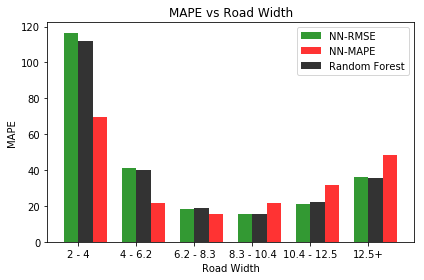

In [40]:
#plot test mape vs road width

n_groups = len(plot_MAPE['Keras'])

 
# create plot
fig, ax = plt.subplots()
index = 1.2*np.arange(n_groups)
bar_width = 0.3
opacity = 0.8

rects1 = plt.bar(index, plot_MAPE['MLP'], bar_width,
                 alpha=opacity,
                 color='g',
                 label='NN-RMSE')

rects2 = plt.bar(index+ 2*bar_width, plot_MAPE['Keras'], bar_width,
                 alpha=opacity,
                 color='r',
                 label='NN-MAPE')

rects2 = plt.bar(index+ bar_width, plot_MAPE['Random Forest'], bar_width,
                 alpha=opacity,
                 color='k',
                 label='Random Forest')
 
plt.xlabel('Road Width')
plt.ylabel('MAPE')
plt.title('MAPE vs Road Width')
plt.xticks(index + bar_width/2, ('2 - 4', '4 - 6.2', '6.2 - 8.3', '8.3 - 10.4', '10.4 - 12.5','12.5+'))
plt.legend()

plt.tight_layout()
plt.savefig('plot_mape.png', bbox_inches='tight')

plt.show()

In [41]:
#calculate CV mape vs road width
bounds=[2,mean-2*std,mean-std,mean,mean+std,mean+2*std,1000]

plot_cvMAPE={}

keras_model=keras_nn_model(X_train.shape[1],'relu',100,0)
keras_model.fit(x=X_train, y=y_train.values.ravel(), batch_size=200, epochs=10, verbose=0, validation_split=0, shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None, validation_steps=None)
pred=keras_model.predict(X_test, batch_size=None, verbose=0, steps=None)
cv,err_matrix=cross_val_keras(X_train, X_test, y_train.values.ravel(), y_test.values.ravel(),100,0,'relu',verbose=0)
mape_error=[]
for i in range(len(bounds)-1):
    mape_error.append(error_bounded(err_matrix,bounds[i],bounds[i+1])[-1])
plot_cvMAPE['Keras']=mape_error


#mlp=MLPRegressor(hidden_layer_sizes=100,activation='relu',solver="adam", max_iter=1000,alpha=1,early_stopping=True,random_state=42,momentum=0,nesterovs_momentum=False)
mlp = MLPRegressor(hidden_layer_sizes=100,activation='relu', max_iter=1000, alpha=1, early_stopping=True,random_state=42)
cv,err_matrix=cross_val(X_train.values, X_test.values, y_train.values.ravel(), y_test.values.ravel(),mlp)
mape_error=[]
for i in range(len(bounds)-1):
    mape_error.append(error_bounded(err_matrix,bounds[i],bounds[i+1])[-1])
plot_cvMAPE['MLP']=mape_error



regr = RandomForestRegressor(n_estimators = 30, min_samples_split = 68, random_state=42)
cv,err_matrix=cross_val(X_train.values, X_test.values, y_train.values.ravel(), y_test.values.ravel(),regr)
mape_error=[]
for i in range(len(bounds)-1):
    mape_error.append(error_bounded(err_matrix,bounds[i],bounds[i+1])[-1])
plot_cvMAPE['Random Forest']=mape_error


reg = linear_model.Ridge(alpha=1)
cv,err_matrix=cross_val(X_train.values, X_test.values, y_train.values.ravel(), y_test.values.ravel(),reg)

mape_error=[]
for i in range(len(bounds)-1):
    mape_error.append(error_bounded(err_matrix,bounds[i],bounds[i+1])[-1])
plot_cvMAPE['Ridge']=mape_error

cv_error:
[ 4.07530997  2.49338751 28.73274039]
cv_error:
[ 3.69721849  2.38070694 33.42367624]
cv_error:
[ 3.7060942   2.37748113 33.30569785]
cv_error:
[ 3.73941669  2.43604495 34.40009569]


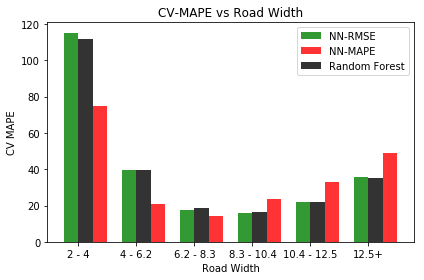

In [42]:
#plot CV mape vs road width
n_groups = len(plot_MAPE['Keras'])

 
fig, ax = plt.subplots()
index = 1.2*np.arange(n_groups)
bar_width = 0.3
opacity = 0.8

rects1 = plt.bar(index, plot_cvMAPE['MLP'], bar_width,
                 alpha=opacity,
                 color='g',
                 label='NN-RMSE')

rects2 = plt.bar(index+ 2*bar_width, plot_cvMAPE['Keras'], bar_width,
                 alpha=opacity,
                 color='r',
                 label='NN-MAPE')

rects2 = plt.bar(index+ bar_width, plot_cvMAPE['Random Forest'], bar_width,
                 alpha=opacity,
                 color='k',
                 label='Random Forest')
 
plt.xlabel('Road Width')
plt.ylabel('CV MAPE')
plt.title('CV-MAPE vs Road Width')
plt.xticks(index + bar_width/2, ('2 - 4', '4 - 6.2', '6.2 - 8.3', '8.3 - 10.4', '10.4 - 12.5','12.5+'))
plt.legend()

plt.tight_layout()
plt.savefig('plot_cvmape.png', bbox_inches='tight')

plt.show()

In [43]:
#learn MAPE test error on various road widths
from numpy.random import seed
seed(42)
from tensorflow import set_random_seed
set_random_seed(42)

test_errors={}
keras_model=keras_nn_model(X_train.shape[1],'relu',100,0)
keras_model.fit(x=X_train, y=y_train.values.ravel(), batch_size=200, epochs=10, verbose=0, validation_split=0, shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None, validation_steps=None)
pred=keras_model.predict(X_test, batch_size=None, verbose=0, steps=None)
test_errors['Keras']=[error_bounded(np.column_stack((y_test.values.ravel(),pred)))]

""
mlp = MLPRegressor(hidden_layer_sizes=100,activation='relu', max_iter=1000, alpha=1, early_stopping=True,random_state=42)
mlp.fit(X_train,y_train.values.ravel())
pred=mlp.predict(X_test)
test_errors['MLP']=[error_bounded(np.column_stack((y_test.values.ravel(),pred)))]

regr = RandomForestRegressor(n_estimators = 30, min_samples_split = 68, random_state=42)
regr.fit(X_train,y_train.values.ravel())
pred = regr.predict(X_test)
test_errors['Random Forest']=[error_bounded(np.column_stack((y_test.values.ravel(),pred)))]

reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)
pred = reg.predict(X_test)
test_errors['OLS']=[error_bounded(np.column_stack((y_test.values.ravel(),pred)))]

reg = linear_model.Ridge(alpha=1)
reg.fit(X_train, y_train)
pred = reg.predict(X_test)
test_errors['Ridge']=[error_bounded(np.column_stack((y_test.values.ravel(),pred)))]


In [44]:
test_errors

{'Keras': [array([ 4.25051561,  2.49219609, 28.37118228])],
 'MLP': [array([ 3.89683149,  2.4250556 , 33.98227759])],
 'Random Forest': [array([ 3.87809218,  2.39154246, 33.35215076])],
 'OLS': [array([ 3.92487715,  2.46244678, 34.54498872])],
 'Ridge': [array([ 3.92253609,  2.45965849, 34.5088499 ])]}